## Spark 'installation' (Don't modify, run once after loading notebook)

### Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Java (and re-direct all output to null)

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Download and unpack Spark

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz

Findspark allow us to locate Spark without exact path

In [ ]:
!pip install -q findspark

Setup the usual environment variables

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Use findspark to start everything

In [ ]:
import findspark
findspark.init()

### Spark context 

Setting up spark context

In [ ]:
import pyspark
conf = (pyspark.SparkConf().setAppName('test').set("spark.executor.memory", "4g").setMaster("local[*]"))
sc = pyspark.SparkContext(conf=conf)

## Optional Spark UI (ngrok)

Output link to Spark UI

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

{"tunnels":[{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://69a1-35-229-29-120.ngrok.io","proto":"http","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://69a1-35-229-29-120.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


In [ ]:
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

## Python and PySpark programming

### Baseline modules (Feel free to add whatever you need)
- numpy

In [ ]:
import numpy as np

### Sequential DBSCAN - Complete

In [ ]:
class Sequential_DBSCAN():
    from scipy.spatial import distance
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_pts = min_samples

    def fit(self, X):
        self.labels_ = -2 * np.ones(X.shape[0])
        self.dist_matrix = self.distance.cdist(X, X, 'euclidean')

        curr_cluster = -1

        for i, pt in enumerate(X):
            if self.labels_[i] != -2:
                continue

            neighbors_ind = set(np.arange(len(X))[np.where(self.dist_matrix[:,i] < self.eps)].flatten())

            if len(neighbors_ind) < self.min_pts:
                self.labels_[i] = -1
                continue
            
            curr_cluster += 1
            self.labels_[i] = curr_cluster

            neighbors_ind.remove(i)

            while len(neighbors_ind) > 0:
                ind = neighbors_ind.pop()
                if self.labels_[ind] == -1:
                    self.labels_[ind] = curr_cluster
                if self.labels_[ind] != -2:
                    continue
                
                new_neighbors_ind = set(np.arange(len(X))[np.where(self.dist_matrix[:,ind] < self.eps)])
                self.labels_[ind] = curr_cluster
                if len(new_neighbors_ind) < self.min_pts:
                    continue

                neighbors_ind.update(new_neighbors_ind)

### Spark DBSCAN (Parallel distance matrix) - Incomplete

aka the first "Dumb DBSCAN" variant

In [ ]:
class Spark_DBSCAN_ParallelDistanceMatrix():
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_pts = min_samples

    def fit(self, X):
        self.labels_ = -2 * np.ones(X.shape[0])

        # TO-DO
        # use Spark to find dist_matrix, and directly collect()
        # self.dist_matrix = self.distance.cdist(X, X, 'euclidean')

        curr_cluster = -1

        for i, pt in enumerate(X):
            if self.labels_[i] != -2:
                continue

            neighbors_ind = set(np.arange(len(X))[np.where(self.dist_matrix[:,i] < self.eps)].flatten())

            if len(neighbors_ind) < self.min_pts:
                self.labels_[i] = -1
                continue
            
            curr_cluster += 1
            self.labels_[i] = curr_cluster

            neighbors_ind.remove(i)

            while len(neighbors_ind) > 0:
                ind = neighbors_ind.pop()
                if self.labels_[ind] == -1:
                    self.labels_[ind] = curr_cluster
                if self.labels_[ind] != -2:
                    continue
                
                new_neighbors_ind = set(np.arange(len(X))[np.where(self.dist_matrix[:,ind] < self.eps)])
                self.labels_[ind] = curr_cluster
                if len(new_neighbors_ind) < self.min_pts:
                    continue

                neighbors_ind.update(new_neighbors_ind)

### Spark DBSCAN (Parallel neighbor quiry) - Incomplete

aka the second "Dumb DBSCAN" variant

In [ ]:
class Spark_DBSCAN_ParallelDistanceMatrix():
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_pts = min_samples

    def fit(self, X):
        self.labels_ = -2 * np.ones(X.shape[0])

        # TO-DO
        # use Spark to find dist_matrix, but cache() only
        # self.dist_matrix = self.distance.cdist(X, X, 'euclidean')

        curr_cluster = -1

        for i, pt in enumerate(X):
            if self.labels_[i] != -2:
                continue

            # TO-DO
            # use Spark to directly find the neighbor list (by index?), need to collect()
            # neighbors_ind = set(np.arange(len(X))[np.where(self.dist_matrix[:,i] < self.eps)].flatten())

            if len(neighbors_ind) < self.min_pts:
                self.labels_[i] = -1
                continue
            
            curr_cluster += 1
            self.labels_[i] = curr_cluster

            neighbors_ind.remove(i)

            while len(neighbors_ind) > 0:
                ind = neighbors_ind.pop()
                if self.labels_[ind] == -1:
                    self.labels_[ind] = curr_cluster
                if self.labels_[ind] != -2:
                    continue
                
                # TO-DO
                # use Spark to directly find the neighbor list (by index?), need to collect()
                # new_neighbors_ind = set(np.arange(len(X))[np.where(self.dist_matrix[:,ind] < self.eps)])

                self.labels_[ind] = curr_cluster
                if len(new_neighbors_ind) < self.min_pts:
                    continue

                neighbors_ind.update(new_neighbors_ind)

### Spark DBSCAN (Grid-based, $\frac{\epsilon}{\sqrt{d}}$)

In [ ]:
from pyspark.sql import SparkSession, Row
spark = SparkSession\
    .builder \
    .appName("Spark DBSCAN") \
    .getOrCreate()

from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
from pyspark.sql.window import Window as W
from pyspark.sql.types import IntegerType

import numpy as np
from numpy.linalg import norm
from queue import SimpleQueue as SQueue

In [ ]:
import time

In [ ]:
from sklearn import datasets

In [ ]:
n_samples = 1000000

# X, _ = datasets.make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
#                                     n_clusters_per_class = 2,
#                                     weights=[.3],
#                                     hypercube=False,
#                                     shift=None,
#                                     scale=None)
# X = np.random.rand(n_samples, 2)
X, _ = datasets.make_blobs(n_samples=[int(n_samples * .1), int(n_samples * .05), int(n_samples * .4), 
                                      int(n_samples * .1), int(n_samples * .2), int(n_samples * 1.5)], n_features=2,
                           centers=None, 
                           cluster_std=[10, 6, 20, 1, 5, 5], 
                           center_box=(-500.0, 500.0), 
                           shuffle=True, random_state=0)

num_exec = 2

eps = 2
min_pt = 10
edge = eps / np.sqrt(2)

rdd_pts = sc.parallelize(X.tolist())
df_pts = spark.createDataFrame(rdd_pts, schema=['x', 'y'])

In [ ]:
t0 = time.time()
df_pts = df_pts.withColumn('point',F.array(df_pts.columns)).select('point')

bound = df_pts.agg(F.min(df_pts.point[0]).alias('min_x'), F.max(df_pts.point[0]).alias('max_x'), 
                   F.min(df_pts.point[1]).alias('min_y'), F.max(df_pts.point[1]).alias('max_y')).first()

grid_offset = (bound['min_x'] - eps/15, bound['min_y'] - eps/15)

df_pts_grids = df_pts.select(df_pts.point,
                             F.floor((df_pts.point[0] - grid_offset[0])/ edge).alias('grid_x'),
                             F.floor((df_pts.point[1] - grid_offset[1])/ edge).alias('grid_y'))

grid_shape = df_pts_grids.agg(F.max(df_pts_grids.grid_x).alias('max_grid_x'),
                              F.max(df_pts_grids.grid_y).alias('max_grid_y')).first()

# TODO: Consecutive index is not needed, replace rdd.zipWithIndex() with grid hash (max_grid_x * grid_x + grid_y)
df_grid_count = df_pts_grids.groupBy(df_pts_grids.grid_x, df_pts_grids.grid_y).agg(F.count(df_pts_grids.point).alias('point_count')) \
                            .orderBy(df_pts_grids.grid_x, df_pts_grids.grid_y)
df_grid_count = df_grid_count.rdd.zipWithIndex().map(lambda x: Row(GID=x[1], grid_x=x[0]['grid_x'], grid_y=x[0]['grid_y'],
                                                                   point_count=x[0]['point_count'])).toDF()
df_grid_count = df_grid_count.select('*',
                                     (df_grid_count.point_count >= min_pt).alias('core_status'),
                                     (F.round(F.log2(df_grid_count.point_count) + df_grid_count.point_count)).alias('c_cost'))

df_pts_grids = df_pts_grids.join(df_grid_count, on=[df_pts_grids.grid_x == df_grid_count.grid_x, df_pts_grids.grid_y == df_grid_count.grid_y]) \
                           .select(df_pts_grids.point, df_grid_count.GID) \
                           .persist()

t1 = time.time()
print(t1 - t0)

26.96234393119812


In [ ]:
# Current implementation uses array in place of a bitmap, but union and intersect operation is far slower
# with array. Sparse vector is a better choice.
# TODO: Use sparse vector instead of array
# TODO: Use sparse vector to also carry grid count information
df_grid_x_set = df_grid_count.groupBy('grid_x').agg(F.collect_list(df_grid_count.GID).alias('grid_x_set'))
df_grid_y_set = df_grid_count.groupBy('grid_y').agg(F.collect_list(df_grid_count.GID).alias('grid_y_set'))

df_grid_x_set_pos2 = df_grid_x_set.select((df_grid_x_set.grid_x + 2).alias('grid_x'), df_grid_x_set.grid_x_set.alias('grid_x_set_pos2'))
df_grid_x_set_pos1 = df_grid_x_set.select((df_grid_x_set.grid_x + 1).alias('grid_x'), df_grid_x_set.grid_x_set.alias('grid_x_set_pos1'))
df_grid_x_set_neg1 = df_grid_x_set.select((df_grid_x_set.grid_x - 1).alias('grid_x'), df_grid_x_set.grid_x_set.alias('grid_x_set_neg1'))
df_grid_x_set_neg2 = df_grid_x_set.select((df_grid_x_set.grid_x - 2).alias('grid_x'), df_grid_x_set.grid_x_set.alias('grid_x_set_neg2'))

df_grid_y_set_pos2 = df_grid_y_set.select((df_grid_y_set.grid_y + 2).alias('grid_y'), df_grid_y_set.grid_y_set.alias('grid_y_set_pos2'))
df_grid_y_set_pos1 = df_grid_y_set.select((df_grid_y_set.grid_y + 1).alias('grid_y'), df_grid_y_set.grid_y_set.alias('grid_y_set_pos1'))
df_grid_y_set_neg1 = df_grid_y_set.select((df_grid_y_set.grid_y - 1).alias('grid_y'), df_grid_y_set.grid_y_set.alias('grid_y_set_neg1'))
df_grid_y_set_neg2 = df_grid_y_set.select((df_grid_y_set.grid_y - 2).alias('grid_y'), df_grid_y_set.grid_y_set.alias('grid_y_set_neg2'))

In [ ]:
df_grid_neighbor = df_grid_count.join(df_grid_x_set, on='grid_x', how='left').join(df_grid_y_set, on='grid_y', how='left') \
                                .join(df_grid_x_set_pos2, on='grid_x', how='left').join(df_grid_y_set_pos2, on='grid_y', how='left') \
                                .join(df_grid_x_set_pos1, on='grid_x', how='left').join(df_grid_y_set_pos1, on='grid_y', how='left') \
                                .join(df_grid_x_set_neg1, on='grid_x', how='left').join(df_grid_y_set_neg1, on='grid_y', how='left') \
                                .join(df_grid_x_set_neg2, on='grid_x', how='left').join(df_grid_y_set_neg2, on='grid_y', how='left') \
                                .select(df_grid_count.GID,
                                        df_grid_count.grid_x, 
                                        df_grid_count.grid_y,
                                        df_grid_count.point_count, 
                                        df_grid_count.core_status,
                                        df_grid_count.c_cost,
                                        F.array_except(F.concat(F.array_intersect(F.concat(F.coalesce(df_grid_x_set_pos1.grid_x_set_pos1, F.array()),
                                                                                           df_grid_x_set.grid_x_set,
                                                                                           F.coalesce(df_grid_x_set_neg1.grid_x_set_neg1, F.array())),
                                                                                  F.concat(F.coalesce(df_grid_y_set_pos2.grid_y_set_pos2, F.array()),
                                                                                           F.coalesce(df_grid_y_set_neg2.grid_y_set_neg2, F.array()))),
                                                                F.array_intersect(F.concat(F.coalesce(df_grid_x_set_pos2.grid_x_set_pos2, F.array()),
                                                                                           F.coalesce(df_grid_x_set_pos1.grid_x_set_pos1, F.array()),
                                                                                           df_grid_x_set.grid_x_set,
                                                                                           F.coalesce(df_grid_x_set_neg1.grid_x_set_neg1, F.array()),
                                                                                           F.coalesce(df_grid_x_set_neg2.grid_x_set_neg2, F.array())),
                                                                                  F.concat(F.coalesce(df_grid_y_set_pos1.grid_y_set_pos1, F.array()),
                                                                                           df_grid_y_set.grid_y_set,
                                                                                           F.coalesce(df_grid_y_set_neg1.grid_y_set_neg1, F.array())))),
                                                       F.array(df_grid_count.GID)).alias('neighbor_GIDs'))
# Intentionally using F.explode_outer to account for grids with no neighbor
# Subsequent aggregation result will not be affected since the columns are NULL
# TODO: This sequence of action (remove self from neighborhood, then consider neighborhood even if NULL) 
# might not be faster. Test the alternative of modifying aggregation formula.
df_grid_neighbor = df_grid_neighbor.withColumn('GID_2', F.explode_outer(df_grid_neighbor.neighbor_GIDs)) \
                                   .join(df_grid_count.select(df_grid_count.GID.alias('GID_2'),
                                                              df_grid_count.point_count.alias('point_count_2'),
                                                              df_grid_count.core_status.alias('core_status_2'),
                                                              df_grid_count.c_cost.alias('c_cost_2')),
                                         'GID_2', how='left')
# Current cost formula is reasonable, but currently U - U grid distances are calculated twice
# Need to update either partition_DBSCAN or cost formula
# TODO: Update cost formula (if U_neighbor is not updated)                                         
df_grid_neighbor = df_grid_neighbor.groupBy(df_grid_neighbor.GID,
                                            df_grid_neighbor.grid_x,
                                            df_grid_neighbor.grid_y,
                                            df_grid_neighbor.point_count,
                                            df_grid_neighbor.core_status,
                                            df_grid_neighbor.neighbor_GIDs) \
                                   .agg(F.coalesce(df_grid_neighbor.point_count * F.sum(df_grid_neighbor.point_count_2) / 2, F.lit(0)).alias('total_cost'),
                                        F.coalesce(F.sum((df_grid_neighbor.c_cost + df_grid_neighbor.c_cost_2) * 
                                                         df_grid_neighbor.core_status_2.astype(IntegerType())) / 2, F.lit(0)).alias('total_c_cost'),
                                        (df_grid_neighbor.point_count + F.coalesce(F.sum(df_grid_neighbor.point_count_2), F.lit(0))).alias('total_neighbor_points'))
df_grid_neighbor = df_grid_neighbor.select(df_grid_neighbor.GID,
                                           df_grid_neighbor.grid_x,
                                           df_grid_neighbor.grid_y,
                                           df_grid_neighbor.neighbor_GIDs,
                                           F.when(df_grid_neighbor.total_neighbor_points < min_pt, F.lit('N')) \
                                            .otherwise(F.when(df_grid_neighbor.core_status, F.lit('C')) \
                                                        .otherwise(F.lit('U'))).alias('grid_status'),
                                           F.when(df_grid_neighbor.total_neighbor_points < min_pt, F.lit(0)) \
                                            .otherwise(F.when(df_grid_neighbor.core_status, df_grid_neighbor.total_c_cost) \
                                                        .otherwise(df_grid_neighbor.total_cost)).alias('final_cost')) \
                                   .persist()

In [ ]:
t2 = time.time()
# There are many different approaches to cumulate cost
# Current cumulative cost is by (grid_x, grid_y) order
total_process_cost = df_grid_neighbor.agg(F.sum(df_grid_neighbor.final_cost).alias('total_cost')).first()['total_cost']
windowval = W.orderBy(df_grid_neighbor.grid_x, df_grid_neighbor.grid_y).rowsBetween(W.unboundedPreceding, W.currentRow)
df_grid_neighbor_w_cumsum = df_grid_neighbor.withColumn('cum_total_cost', F.sum(df_grid_neighbor.final_cost).over(windowval))
# TODO: Modify the partition value calculation so it works with arbitrary number of executors
# df_grid_neighbor_w_cumsum = df_grid_neighbor_w_cumsum.select('*', F.when(df_grid_neighbor_w_cumsum.cum_total_cost <= total_process_cost / 2, F.lit(0))
#                                                                    .otherwise(F.lit(1)).alias('partition'))
df_grid_neighbor_w_cumsum = df_grid_neighbor_w_cumsum.select('*', 
                                                             F.floor(df_grid_neighbor_w_cumsum.cum_total_cost/ total_process_cost * num_exec) \
                                                             .alias('partition'))

df_partition_grids = df_grid_neighbor_w_cumsum.withColumn('GID_needed', F.explode(F.array_union(df_grid_neighbor_w_cumsum.neighbor_GIDs,
                                                                                                F.array(df_grid_neighbor_w_cumsum.GID)))) \
                                              .groupBy(df_grid_neighbor_w_cumsum.partition) \
                                              .agg(F.max(df_grid_neighbor_w_cumsum.GID).alias('GID_boundary'), 
                                                   F.collect_set('GID_needed').alias('partition_needed_GIDs')) \
                                              .persist()

# Each partition needs to know the range of grids (GIDs) it will actively cluster
# As this information is basically free while we collect the list of GIDs needed by each partition, it is collected.                                                  
partition_boundaries = [-1] + [row[0] for row in df_partition_grids.select('GID_boundary').collect()]


t3 = time.time()

print(t3-t2)

80.54667568206787


In [ ]:
def partition_DBSCAN(splitIndex, it):
    """Perform DBSCAN on the partition of splitIndex. Each datum is accessed through it (the iterator).

    Parameters:
    splitIndex: int
                0-based index of the partition
    it: iterator of (splitIndex, (GID, grid_status, list of points in the grid, list of neighbor grid GIDs))
        Each datum in the partition contains a single grid, with all the points inside and additional information crucial to the algorithm.

    Global variables:
    eps: float
         Parameter of DBSCAN. Determines the size of neighborhood (2-norm ball) about a point to consider its density.
    min_pt: int
            Parameter of DBSCAN. Determines the density threshold for a point to be a core point of a cluster.

    Outputs:


    partition_DBSCAN is an exact DBSCAN algorithm (i.e. produce the standard DBSCAN result) for d-dimensional Euclidean space.
    It is a grid-based algorithm (with grid of side length eps/sqrt(d)) that is designed to work with spatially divided subset of data while
    minimizing the number of distance calculations. For it to be feasible to run multiple independent partition_DBSCAN computations on different
    subset of data, additional information that is needed to merge the individual results into the standard DBSCAN result is stored and returned.

    The eps/sqrt(d) grid imposed on the d-dimensional space has the following 2 properties:
    1) For any grid, if there is at least one core point inside, every point in the grid is in the same cluster (as the core point).
    2) For any point A in a grid, every point that are inside the neighborhood of A can only be in a specific set of surrounding grids.
       For d = 2, this set of grids looks like:
         ooo
        ooooo
        ooxoo
        ooooo
         ooo

    The central idea of partition_DBSCAN is the following classification of grids using the threshold min_pt:
    - C grid: a grid that has at least min_pt points.
      This implies that all and every point in the grid are core points.
    - N grid: a grid that have less than min_pt points in the entire grid neighborhood.
      This implies none of the points in the grid are core points.
    - U grid: a grid that is not C grid nor N grid.
    In DBSCAN, core points within each other's neighborhood are clustered together. The classification allow us to harness the symmetry in this
    requirement with a lot less distance calculation:

    Stage 1) All C grids are clustered sequentially.
    - Since C grids are internally connected by definition, any single connection between two C grids is sufficient and number of distance
      calculations is greatly reduced.

    Stage 2) All U grids are clustered sequentially, but now include all C grids, U grids and N grids into the clusters.
             Using U grids to initialize cluster formation further cut distance calculations concerning C grids. Specific information is stored
             in (union-find-like) data structure to form clusters.
    - Starting calculations from C grids to U grids tend to 'waste' some calculations by reaching the same points again.
      Early termination (not considering every point in the C grid) is only possible if all neighboring points are reached.
      This is not the case if we are starting from U grids instead - there is much less 'waste' since each point needs the neighbor query to check
      if core point anyway and the number of point in U grid is bounded by min_pt.
    - No core grids (grids with discovered core points) need to be visited twice.
      A key signature - maximality - of sequential DBSCAN algorithms. This applies to both Stage 1) and Stage 2).
    - Border points in a core grid also does not need any additional memory to store.
    - Merging cluster is very efficient with an union-find-like data structure.
      The deliberate choice of clustering C grids first has several implications here.
      A) By the maximality of the sequential algorithms, merging two clusters is only needed when a U grid cluster reaches one or more C grid clusters.
         This means only C grid clusters will have a chance of being merged more than once.
         All U grid clusters are always leaf nodes.
         The tree formed is already flattened since the U grid cluster and other C grid clusters can directly point to the root.
      B) Since C grid clusters are formed first, they have a lower cluster label (CID), and following the convention of union-find that the root node
         has the smallest label, the root is always a C grid for any cluster with both U grids and C grids.
      We can then infer that the maximum height of a tree in union-find is bounded by the number of C clusters (which behavior is a lot more constrained
      than number of C grids), and the cost of merging is minimal.
    """
    # Partition-wide CID
    # CID_list is for union-find-like data structure to connect grids with different CIDs.
    next_CID = 0
    CID_list = []

    # Any grid that has at least 1 core point is a core grid and part of a cluster
    # As such, the starting core grid of each cluster is assigned a CID, and appended to CID list
    # - a new CID is akin to make_set() in union find
    # - CID_list is then the storage for parent index of each CID
    core_grid_CID_map = {}

    # Partition-wide ghost linkage
    # Keep track of confirmed and potential linkages to ghost grids
    # ghost_grid_linkage handles the following two cases, where the linkage is guaranteed:
    # - a core point in C grid reaching a point in ghost C grid
    # - a core point in core U grid reaching a point in ghost C grid
    # ghost_point_linkage handles the remaining case where linkage depends on if both sides are core point:
    # - a core point in core U grid reaching a point in ghost U grid
    # Note: border points in ghost N grid are treated like normal border points (see border_point_CID_map)
    # In case of conflict between partition, lower CID will take precedence
    # TODO: Invert the key and values of ghost_grid_linkage
    ghost_grid_linkage = {}
    ghost_point_linkage = {}

    # Any point outside of core grids can only be border point (need to store CID) and noise (nothing to do).
    # Border points are either handled locally
    # - border_point_CID_map handles border points of (local) U grid and (local and ghost) N grid
    # Or during merging
    # - ghost_point_linkage handles 'border points' (that could be core points instead) of (ghost) U grid
    # - border_point_ghost_GID_map handles border points of (local) U grid reachable from a ghost C grid
    border_point_CID_map = {}
    border_point_ghost_GID_map = {}

    # Grid data from earlier data processing
    grid_status_map = {}
    grid_points_map = {}
    grid_neighbors_map = {}

    # grid_data[1] is of the form (GID, grid_status, list of points in the grid, list of neighbor grid GIDs)
    # core_grid_CID_map is also serving to record if a (local) C/ U grid is a core grid
    # - local grids that are not core grids all have  -1.
    # - ghost grids all have -2.
    for grid_data in it:
        if grid_data is None:
            break
        grid_status_map[grid_data[1][0]] = grid_data[1][1]
        grid_points_map[grid_data[1][0]] = [tuple(point) for point in grid_data[1][2]]
        grid_neighbors_map[grid_data[1][0]] = grid_data[1][3]
        if partition_boundaries[splitIndex] < grid_data[1][0] <= partition_boundaries[splitIndex + 1]:
            core_grid_CID_map[grid_data[1][0]] = -1
        else:
            core_grid_CID_map[grid_data[1][0]] = -2

    # Helper functions
    # Check if two C grids are connected
    def C2C_connected(this_GID, that_GID):
        # TODO: Optimize by filtering points that are far away from the other grid
        return any(norm((point_here[0] - point_there[0], point_here[1] - point_there[1])) <= eps
                   for point_here in grid_points_map[this_GID] for point_there in grid_points_map[that_GID])

    # Collect the neighboring points (inside grid of that_GID) of point_here inside a U grid
    # TODO: Update U_neighbor so it utilize some kind of global adjacency list
    def U_neighbor(point_here, that_GID):
        point_neighbors = []
        # Necessary to know exactly what points are in the neighborhood and cannot include the whole neighbor grid directly
        for point_there in grid_points_map[that_GID]:
            # TODO: Optimize by filtering out points far away from grid corner
            if norm((point_here[0] - point_there[0], point_here[1] - point_there[1])) <= eps:
                point_neighbors.append(point_there)
        return point_neighbors

    # TODO: Do we need more or fewer such wrapper functions?
    # Wrapper function to reduce clutter
    def is_ghost_grid(GID):
        return core_grid_CID_map[GID] == -2

    ### Main loop
    # C grid is not only listed first, but actually need to be processed first as well.
    for GID, grid_status in grid_status_map.items():
        # Skip ghost grids
        if is_ghost_grid(GID):
            continue
        elif grid_status == 'C':
            ### Standard Sequential DBSCAN with only C grids
            if core_grid_CID_map[GID] >= 0:
                continue

            # Unvisited core grids always get a new CID
            CID = next_CID
            CID_list.append(CID)
            next_CID += 1

            core_grid_CID_map[GID] = CID

            connected_C_grid_neighbor_GIDs = SQueue()
            for neighbor_GID in grid_neighbors_map[GID]:
                if grid_status_map[neighbor_GID] == 'C' and C2C_connected(GID, neighbor_GID):
                    if is_ghost_grid(neighbor_GID):
                        temp_set = ghost_grid_linkage.get(neighbor_GID, set())
                        temp_set.add(GID)
                        ghost_grid_linkage[neighbor_GID] = temp_set
                    else:
                        connected_C_grid_neighbor_GIDs.put(neighbor_GID)

            while not connected_C_grid_neighbor_GIDs.empty():
                connected_C_grid_neighbor_GID = connected_C_grid_neighbor_GIDs.get()

                if core_grid_CID_map[connected_C_grid_neighbor_GID] >= 0:
                    continue

                core_grid_CID_map[connected_C_grid_neighbor_GID] = CID

                for further_connected_C_grid_neighbor_GID in grid_neighbors_map[connected_C_grid_neighbor_GID]:
                    # if further_connected_C_grid_neighbor_GID not in grid_status_map:
                    #     raise KeyError(f'Split:{splitIndex}, Key problem: {further_connected_C_grid_neighbor_GID}, source GID: {GID}')
                    if grid_status_map[further_connected_C_grid_neighbor_GID] == 'C' and \
                            C2C_connected(connected_C_grid_neighbor_GID, further_connected_C_grid_neighbor_GID):
                        if is_ghost_grid(further_connected_C_grid_neighbor_GID):
                            temp_set = ghost_grid_linkage.get(further_connected_C_grid_neighbor_GID, set())
                            temp_set.add(connected_C_grid_neighbor_GID)
                            ghost_grid_linkage[further_connected_C_grid_neighbor_GID] = temp_set
                        else:
                            connected_C_grid_neighbor_GIDs.put(further_connected_C_grid_neighbor_GID)

        elif grid_status == 'U':
            ### Modified Sequential DBSCAN to handle U-C, U-U and U-N connections.
            # Skip grid if it is a core grid and already processed
            if core_grid_CID_map[GID] >= 0:
                continue
            else:
                ### Initial exploration - the whole U grid is explored.
                # Cluster-wide data structure
                # 1) border_points_so_far: a set of border points encountered in the current exploration
                #    There are three main ways a border point is reached
                #    Z) Inside a U grid where a core point is found
                #    A) Inside a U grid cluster exploration
                #    B) The border point is found to be reachable from a point in a C grid
                #    Precedence
                #    - Z) always takes precedence at the end if Z) is true
                #    - Otherwise, A) and B) take precedence by processing order
                border_points_so_far = set()
                # 2) reachable_C_grid_CIDs: Store the CID of C grids encountered while exploring the current cluster
                #    - To determine the CID of the current cluster
                #    - To update C grid CIDs if they are 'glued together' in the current cluster
                reachable_C_grid_CIDs = set()
                # 3) grids_to_explore: All further grids to explore
                #    There is building upon grid_all_point_neighborhood - necessary since different core points in a U grid do reach
                #    different points - and we want to consider all such points in a grid at the same time
                grids_to_explore = SQueue()

                # Grid local data structure
                # 1) point_count: Total point count in the grid
                # TODO: Only U grid needs point count - is it better to recalculate or just carry along the information?
                point_count = len(grid_points_map[GID])
                # 2) grid_all_point_neighborhood: A dict of neighbor_GID: points reachable
                #    Only updated if the point considered is a core point
                grid_all_point_neighborhood = {}

                for point in grid_points_map[GID]:
                    # Skip border points that are already reached
                    if point in border_point_CID_map:
                        continue

                    # Point temporary data structure
                    # The weird asymmetry here has great significance:
                    # - There is no reason for border points in a core grid to waste processing resources by being in border_point_CID_map
                    # - However, we can only remove them after all points are explored and knowing we have at least 1 core point.
                    # - This is not a problem for core point and as soon as we know it is a core point, we can save the information
                    # As a result of the processing logic, we need the asymmetric storages
                    # 1) directly_reachable_C_grid_CIDs: a list of (local) C grid CIDs
                    #    - For border points reachable from (local) C grid:
                    #      Update border_point_CID_map, which is processed at the very end
                    #    - For core points:
                    #      Update reachable_C_grid_CIDs for (local) C grids to 'clue together'
                    #      Update ghost_grid_linkage for merging stage
                    # 2) directly_reachable_ghost_C_grid_GIDs: a list of (ghost) C grid GIDs
                    #    - For border points reachable from (ghost) C grid:
                    #      Update border_point_ghost_GID_map for merging stage
                    directly_reachable_C_grid_CIDs = []
                    directly_reachable_ghost_C_grid_GIDs = []
                    # 3) exact_point_neighborhood: a dict of neighbor CID: points reachable
                    #    - For core points: keep track of points in other U grid that need to be explored
                    exact_point_neighborhood = {}
                    # 4) total_neighbor_point_count: number of neighbors used in min_pt comparison
                    total_neighbor_point_count = 0

                    for neighbor_GID in grid_neighbors_map[GID]:
                        exact_point_neighbors = U_neighbor(point, neighbor_GID)
                        if len(exact_point_neighbors) == 0:
                            continue
                        else:
                            if grid_status_map[neighbor_GID] == 'C':
                                if is_ghost_grid(neighbor_GID):
                                    directly_reachable_ghost_C_grid_GIDs.append(neighbor_GID)
                                else:
                                    directly_reachable_C_grid_CIDs.append(core_grid_CID_map[neighbor_GID])
                            else:
                                exact_point_neighborhood[neighbor_GID] = exact_point_neighbors
                            total_neighbor_point_count += len(exact_point_neighbors)

                    # Store the information as if there is no core point here
                    # border_point_so_far not invoked here at all has great significance
                    # - If there is no core point, there is no cluster to speak of, and no reason to update border_point_so_far
                    # - If there is a core point, there is no need to store border point information at all
                    if point_count + total_neighbor_point_count < min_pt:
                        # TODO: Perhaps skip the storing steps when we have found a core point?
                        # TODO: Selecting the first C grid with no reason at all - need any rules?
                        if len(directly_reachable_C_grid_CIDs) > 0:
                            border_point_CID_map[point] = directly_reachable_C_grid_CIDs[0]
                        elif len(directly_reachable_ghost_C_grid_GIDs) > 0:
                            border_point_ghost_GID_map[point] = directly_reachable_ghost_C_grid_GIDs[0]
                        continue
                    else:
                        # Current point is now a core point
                        # Perform update when grid is promoted to core grid
                        if core_grid_CID_map[GID] == -1:
                            CID = next_CID
                            CID_list.append(CID)
                            next_CID += 1
                            # Skipping this grid the next time
                            core_grid_CID_map[GID] = CID

                        # Perform update regarding reachable (local) C grid
                        reachable_C_grid_CIDs.update(directly_reachable_C_grid_CIDs)
                        for ghost_GID in directly_reachable_ghost_C_grid_GIDs:
                            temp_set = ghost_grid_linkage.get(ghost_GID, set())
                            temp_set.add(GID)
                            ghost_grid_linkage[ghost_GID] = temp_set

                        # Update grid_all_point_neighborhood so we can continue exploration
                        # Reminder: Only U and N grid here
                        for neighbor_GID, exact_point_neighbors in exact_point_neighborhood.items():
                            # Only ghost U grid has the potential to form linkage
                            # Moreover, unlike ghost N grid which we can just include the border points locally (later), the status
                            # of ghost U grid can only be handled after partition clustering is complete
                            if is_ghost_grid(neighbor_GID) and grid_status_map[neighbor_GID] == 'U':
                                ghost_point_linkage[(GID, point)] = (neighbor_GID, exact_point_neighbors)
                            else:
                                temp_set = grid_all_point_neighborhood.get(neighbor_GID, set())
                                temp_set.update(exact_point_neighbors)
                                grid_all_point_neighborhood[neighbor_GID] = temp_set

                # Remove border point reference that are no longer needed when grid is a core grid
                if core_grid_CID_map[GID] >= 0:
                    for point in grid_points_map[GID]:
                        if point in border_point_CID_map:
                            del border_point_CID_map[point]
                        elif point in border_point_ghost_GID_map:
                            del border_point_ghost_GID_map[point]

                # Initialize our queue of GIDs to explore
                for neighbor_GID, exact_point_neighbors in grid_all_point_neighborhood.items():
                    grids_to_explore.put((neighbor_GID, list(exact_point_neighbors)))

                while not grids_to_explore.empty():
                    next_GID, next_point_neighbors = grids_to_explore.get()

                    # Reminder: Only U grid and N grid here
                    # Skip next_GID if it is a core grid and already processed
                    if core_grid_CID_map[next_GID] >= 0:
                        continue
                    # Include the reachable points in N grid into border_points_so_far
                    elif grid_status_map[next_GID] == 'N':
                        border_points_so_far.update(next_point_neighbors)
                        continue
                    else:
                        # Grid local data structure
                        # All equivalent variables have a 'next_' prefix
                        # 1) next_point_count: Total point count in the grid
                        # 2) next_grid_all_point_neighborhood: A dict of neighbor_GID: points reachable
                        next_point_count = len(grid_points_map[next_GID])
                        next_grid_all_point_neighborhood = {}

                        # Diverging point
                        # Special data structure
                        # S) potential_points_to_explore_if_core: A list of points in the grid not reachable before
                        #    Special data structure, if we reached a core point in this grid, we will immediately consider
                        #    all remaining points in the grid as well since we are not returning
                        potential_points_to_explore_if_core = [next_point for next_point in grid_points_map[next_GID]
                                                               if next_point not in next_point_neighbors]
                        # As a result, a queue is needed instead of a simple for loop
                        next_point_neighbors_queue = SQueue()
                        for next_point in next_point_neighbors:
                            next_point_neighbors_queue.put(next_point)

                        while not next_point_neighbors_queue.empty():
                            next_point = next_point_neighbors_queue.get()

                            # The reason of all these cases:
                            # - For border_point_CID_map and border_point_ghost_GID_map:
                            #   The grid has been the start of exploration (with no core point), no need to recalculate
                            # - For border_points_so_far
                            #   The point is reached earlier in this exploration already. This is possible precisely when the earlier exploration
                            #   did not find a core point
                            if (next_point in border_point_CID_map or next_point in border_point_ghost_GID_map or
                                    next_point in border_points_so_far):
                                continue

                            # Point temporary data structure
                            # All equivalent variables have a 'next_' prefix
                            # 1) next_directly_reachable_C_grid_CIDs: a list of (local) C grid CIDs
                            # 2) next_directly_reachable_ghost_C_grid_GIDs: a list of (ghost) C grid CIDs
                            # 3) next_exact_point_neighborhood: a dict of neighbor CID: points reachable
                            # 4) next_total_neighbor_point_count: number of point in neighbor grids
                            next_directly_reachable_C_grid_CIDs = []
                            next_directly_reachable_ghost_C_grid_GIDs = []
                            next_exact_point_neighborhood = {}
                            next_total_neighbor_point_count = 0

                            for further_neighbor_GID in grid_neighbors_map[next_GID]:
                                next_exact_point_neighbors = U_neighbor(next_point, further_neighbor_GID)
                                if len(next_exact_point_neighbors) == 0:
                                    continue
                                else:
                                    if grid_status_map[further_neighbor_GID] == 'C':
                                        if is_ghost_grid(further_neighbor_GID):
                                            next_directly_reachable_ghost_C_grid_GIDs.append(further_neighbor_GID)
                                        else:
                                            next_directly_reachable_C_grid_CIDs.append(
                                                core_grid_CID_map[further_neighbor_GID])
                                    # No need to return to a core grid
                                    # Ghost grids are filter out later
                                    elif core_grid_CID_map[further_neighbor_GID] < 0:
                                        next_exact_point_neighborhood[further_neighbor_GID] = next_exact_point_neighbors
                                    next_total_neighbor_point_count += len(next_exact_point_neighbors)

                            # Diverging point
                            # We are in a cluster now, border points can safely ignore C grid
                            if next_point_count + next_total_neighbor_point_count < min_pt:
                                border_points_so_far.add(next_point)
                                continue
                            else:
                                # Perform update when grid is promoted to core grid
                                if core_grid_CID_map[next_GID] == -1:
                                    core_grid_CID_map[next_GID] = CID
                                    # Include all points in the current grid into consideration once the first core point is found
                                    for next_point in potential_points_to_explore_if_core:
                                        next_point_neighbors_queue.put(next_point)

                                reachable_C_grid_CIDs.update(next_directly_reachable_C_grid_CIDs)
                                for ghost_GID in next_directly_reachable_ghost_C_grid_GIDs:
                                    next_temp_set = ghost_grid_linkage.get(ghost_GID, set())
                                    next_temp_set.add(next_GID)
                                    ghost_grid_linkage[ghost_GID] = next_temp_set

                                for further_neighbor_GID, next_exact_point_neighbors in next_exact_point_neighborhood.items():
                                    # Only ghost U grid has the potential to form linkage
                                    # See the analogous part above
                                    if is_ghost_grid(further_neighbor_GID) and grid_status_map[further_neighbor_GID] == 'U':
                                        ghost_point_linkage[(next_GID, next_point)] = (further_neighbor_GID, next_exact_point_neighbors)
                                    else:
                                        next_temp_set = next_grid_all_point_neighborhood.get(further_neighbor_GID,
                                                                                             set())
                                        next_temp_set.update(next_exact_point_neighbors)
                                        next_grid_all_point_neighborhood[further_neighbor_GID] = next_temp_set

                        # We can safely delete all border points in core grid
                        if core_grid_CID_map[next_GID] >= 0:
                            for point in grid_points_map[next_GID]:
                                if point in border_point_CID_map:
                                    del border_point_CID_map[point]
                                elif point in border_point_ghost_GID_map:
                                    del border_point_ghost_GID_map[point]

                        for further_neighbor_GID, next_exact_point_neighbors in next_grid_all_point_neighborhood.items():
                            grids_to_explore.put((further_neighbor_GID, list(next_exact_point_neighbors)))

                # Form clusters with the union-find-like data structure
                if len(reachable_C_grid_CIDs) > 0:
                    candidate_CIDs_list = list(reachable_C_grid_CIDs)

                    path_CIDs = []

                    for candidate_CID in candidate_CIDs_list:
                        path_CIDs.append(candidate_CID)
                        while CID_list[candidate_CID] != candidate_CID:
                            candidate_CID = CID_list[candidate_CID]
                            path_CIDs.append(candidate_CID)

                    min_CID = min(path_CIDs)

                    for path_CID in path_CIDs:
                        CID_list[path_CID] = min_CID

                    CID_list[CID] = min_CID

                for border_point in border_points_so_far:
                    border_point_CID_map[border_point] = CID_list[CID]

    yield (core_grid_CID_map, CID_list, border_point_CID_map, ghost_grid_linkage, ghost_point_linkage, border_point_ghost_GID_map)


In [ ]:
def partition_cluster_merge(partition_cluster_infos):
    """
    Merge the results from mapPartition(partition_DBSCAN).

    Two type of merge tasks need to be performed:
    1) Cross-partition clusters needed to share the same CID
    2) Border points that belongs to cluster in another partition needs to be labelled
    Task 1) will be performed first so task 2) can just use the updated CIDs.

    Parameters:
    partition_cluster_infos: a list of
    (core_grid_CID_map, CID_list, border_point_CID_map, ghost_grid_linkage, ghost_point_linkage, border_point_ghost_GID_map)

    Outputs:
    overall_core_grid_CID_map: a dict of {GID: CID}
    overall_border_point_CID_map: a dict of {point: CID}
    """

    cum_num_clusters = 0
    overall_core_grid_CID_map = {}
    overall_CID_list = []
    overall_border_point_CID_map = {}
    overall_ghost_grid_linkage = {}
    overall_ghost_point_linkage = {}
    overall_border_point_ghost_GID_map = {}

    for partition_cluster_info in partition_cluster_infos:
        # Don't include grids that are non-core grids
        overall_core_grid_CID_map.update({k: (v + cum_num_clusters) for k, v in partition_cluster_info[0].items() if v >= 0})
        overall_CID_list += [CID + cum_num_clusters for CID in partition_cluster_info[1]]
        overall_border_point_CID_map.update({k: (v + cum_num_clusters) for k, v in partition_cluster_info[2].items()})

        for ghost_GID, core_GIDs in partition_cluster_info[3].items():
            temp_list = overall_ghost_grid_linkage.get(ghost_GID, [])
            temp_list += core_GIDs
            overall_ghost_grid_linkage[ghost_GID] = temp_list

        overall_ghost_point_linkage.update(partition_cluster_info[4])
        overall_border_point_ghost_GID_map.update(partition_cluster_info[5])

        cum_num_clusters = len(overall_CID_list)

    for GID_core_point, GID_ghost_points in overall_ghost_point_linkage.items():
        core_GID = GID_core_point[0]
        ghost_GID = GID_ghost_points[0]

        # If the ghost grid is core, we only need to care if there is an actual linkage.
        # Border points handling is only needed if ghost grid is not a core grid.
        if ghost_GID in overall_core_grid_CID_map:
            for ghost_point in GID_ghost_points[1]:
                if (ghost_GID, ghost_point) in overall_ghost_point_linkage:
                    temp_list = overall_ghost_grid_linkage.get(ghost_GID, [])
                    temp_list.append(core_GID)
                    overall_ghost_grid_linkage[ghost_GID] = temp_list
                    break
        else:
            for ghost_point in GID_ghost_points[1]:
                overall_border_point_CID_map[ghost_point] = overall_core_grid_CID_map[core_GID]


    for ghost_GID, core_GIDs in overall_ghost_grid_linkage.items():
        ghost_CID = overall_core_grid_CID_map[ghost_GID]
        core_CIDs = [overall_core_grid_CID_map[core_GID] for core_GID in core_GIDs]
        candidate_CIDs_list = [ghost_CID] + core_CIDs

        path_CIDs = []

        for candidate_CID in candidate_CIDs_list:
            path_CIDs.append(candidate_CID)
            while overall_CID_list[candidate_CID] != candidate_CID:
                candidate_CID = overall_CID_list[candidate_CID]
                path_CIDs.append(candidate_CID)

        min_CID = min(path_CIDs)

        for path_CID in path_CIDs:
            overall_CID_list[path_CID] = min_CID         

    # TODO: Find a less awkward way to create final_CID_list
    # Updating all CID gives us extra guarantees
    final_CID_list = []
    for CID in overall_CID_list:
        final_CID = overall_CID_list[CID]
        while final_CID != overall_CID_list[final_CID]:
            final_CID = overall_CID_list[final_CID]
        final_CID_list.append(final_CID)

    overall_CID_list = final_CID_list

    overall_core_grid_CID_map = {GID: overall_CID_list[CID] for GID, CID in overall_core_grid_CID_map.items()}
    overall_border_point_CID_map = {point: overall_CID_list[CID] for point, CID in overall_border_point_CID_map.items()}
    overall_border_point_CID_map.update({point: overall_core_grid_CID_map[GID] for point, GID in overall_border_point_ghost_GID_map.items()})

    return overall_core_grid_CID_map, overall_border_point_CID_map


In [ ]:
t4 = time.time()

# We will first cluster the local C grids, which requires C grids to come before U grids in the RDD.
# The C grid are also sorted with increasing cost (the naive way of checking if two C grids are connected favor starting from those with fewer points.)
# - As we are partitioning later on 'partition' and sorting on 'grid_status', RDD.repartitionAndSortWithinPartitions() cannot be used.
# TODO: Only put C grid in front and ignore N grid and U grid.
# The gain from this is not completely clear.
# TODO: Test if sorting by cost is necessary at all. If not, we can just repartition by 'partition'.
rdd_pts_processed = df_partition_grids.withColumn('GID', F.explode('partition_needed_GIDs')) \
                                      .join(df_pts_grids.groupBy(df_pts_grids.GID).agg(F.collect_list('point').alias('points')),
                                             'GID') \
                                      .join(df_grid_neighbor, 
                                            'GID') \
                                      .select(df_partition_grids['partition'],
                                              'GID', df_grid_neighbor['grid_status'], 
                                              'points', df_grid_neighbor['neighbor_GIDs']) \
                                      .orderBy(df_grid_neighbor.grid_status, df_grid_neighbor.final_cost) \
                                      .rdd.map(lambda r: (r[0], (r[1], r[2], r[3], r[4])))
rdd_pts_processed = rdd_pts_processed.partitionBy(num_exec)

rdd_partition_cluster = rdd_pts_processed.mapPartitionsWithIndex(partition_DBSCAN)
partition_cluster_infos = rdd_partition_cluster.collect()

overall_core_grid_CID_map, overall_border_point_CID_map = partition_cluster_merge(partition_cluster_infos)

# Pass grid and border point CID information to the original DataFrames since the drive program does not have GID information.
df_core_grid_CID = spark.createDataFrame(overall_core_grid_CID_map.items(), schema=['GID', 'CID'])
df_border_point_CID = spark.createDataFrame(overall_border_point_CID_map.items(), schema=['point', 'CID'])
df_border_point_CID = df_border_point_CID.select(F.array(df_border_point_CID.point['_1'], df_border_point_CID.point['_2']).alias('point'),
                                                 df_border_point_CID.CID)

# Collect result for plotting
results = df_pts_grids.join(df_core_grid_CID, on='GID', how='left') \
                      .join(df_border_point_CID, on='point', how='left') \
                      .select(df_pts_grids.point, F.coalesce(df_core_grid_CID.CID, df_border_point_CID.CID, F.lit(-1)).alias('label')).collect()
points, labels = map(list, zip(*results))

t5 = time.time()
print(t5 - t4)

476.58506321907043


In [ ]:
# TODO: Find permenant location for clean up
points_array = np.array(points)

# This part is necessary only if the final CIDs need to be consecutive
# Find all the CIDs that are not used
skipped_CID = []
for i in range(max(labels) + 1):
    if i not in labels:
        skipped_CID.append(i)

# Require all CIDs to 'jump ahead' to the correct location
# TODO: Use the previously calculated value in label_reduce_map
label_reduce_map = {}
for i in range(max(labels) + 1):
    label_reduce_map[i] = i - sum(v < i for v in skipped_CID)

reduced_labels = [label_reduce_map[label] if label != -1 else -1 for label in labels]

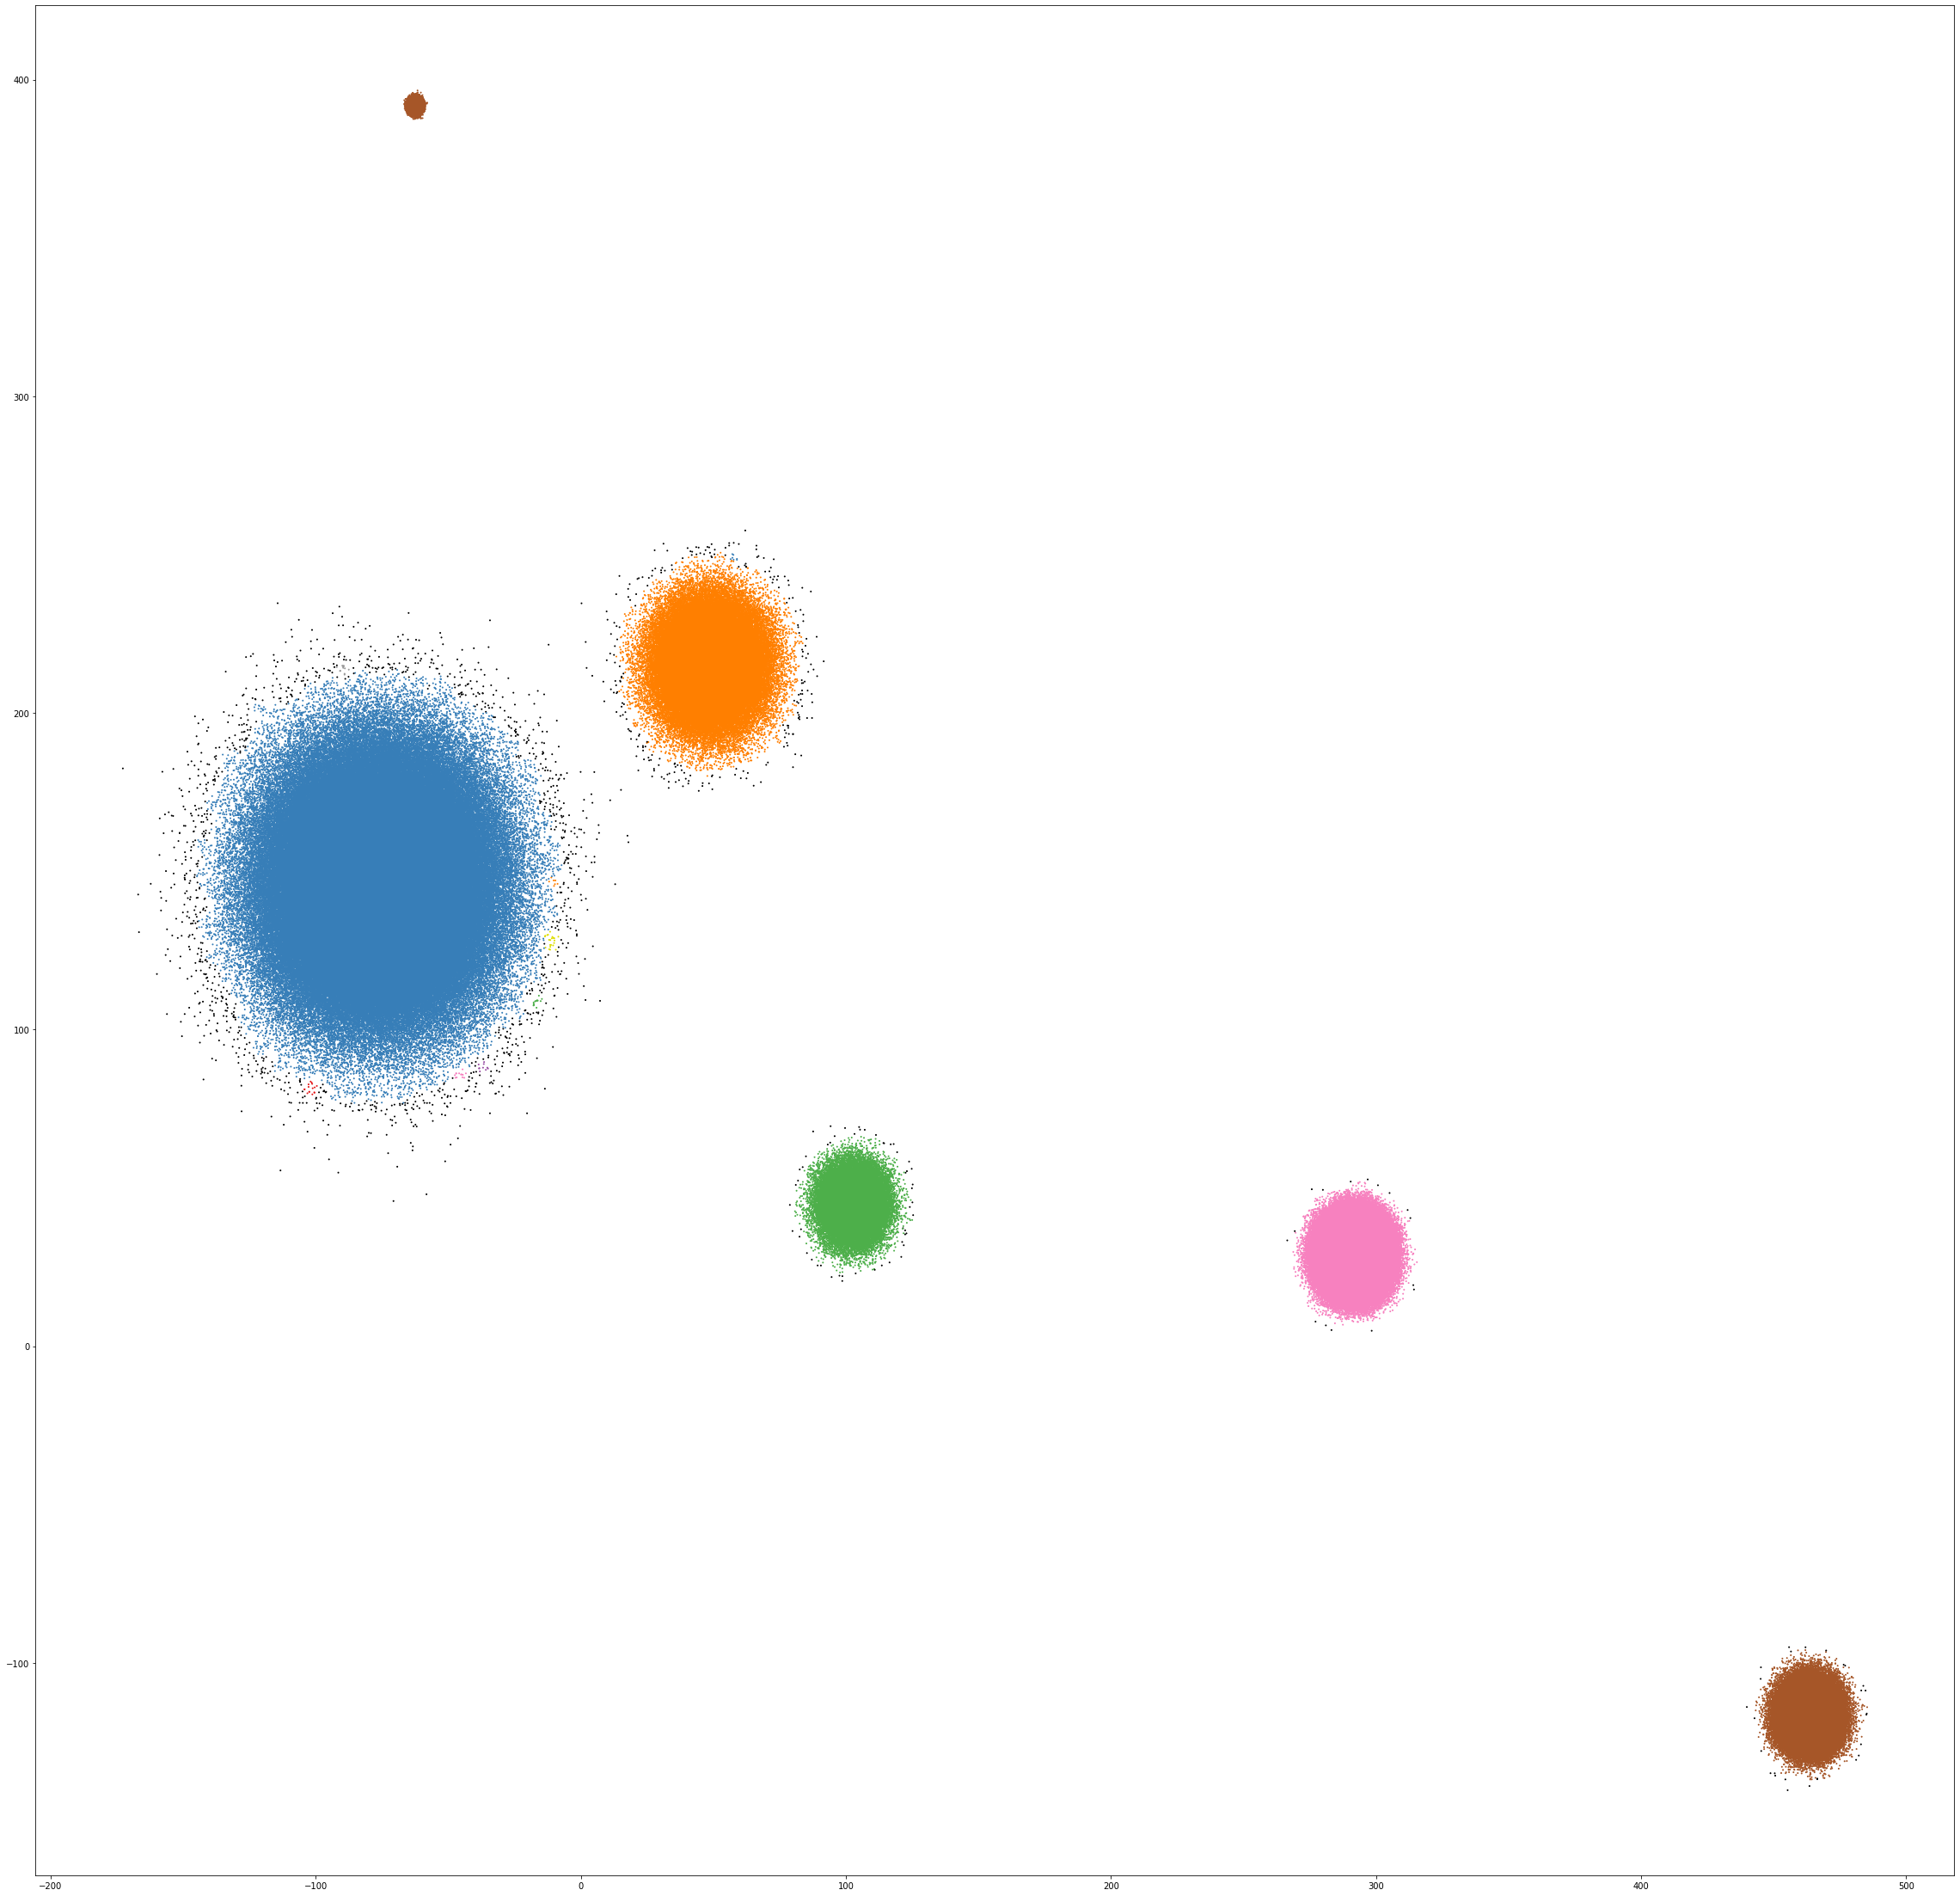

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle, islice

plt.figure(figsize=(40,40))
colors = np.array(list(islice(cycle(["#377eb8",
                                             "#ff7f00",
                                             "#4daf4a",
                                             "#f781bf",
                                             "#a65628",
                                             "#984ea3",
                                             "#999999",
                                             "#e41a1c",
                                             "#dede00",]),
                                      int(max(reduced_labels) + 1),)))
colors = np.append(colors, ["#000000"])

plt.scatter(points_array[:, 0], points_array[:, 1], s=1, color=colors[reduced_labels])

plt.show()

## Scikit-learn clustering dataset


In [ ]:
import time
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import matplotlib.pyplot as plt

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

default_base = {"eps": 0.3, "min_samples": 5}

###
### CHANGE DATASET/ NUMBER OF ALGORITHM
# set the number of DBSCAN algorithms to compare
num_DBSCAN_algorithms = 2

# test other parameters by adding a new tuple
# e.g. (noisy_circles,{"eps": 0.3, "min_samples": 10})
datasets = [(noisy_circles,{},),
            (noisy_moons, {}),
            (blobs, {}),
            (no_structure, {}),]
### END
###

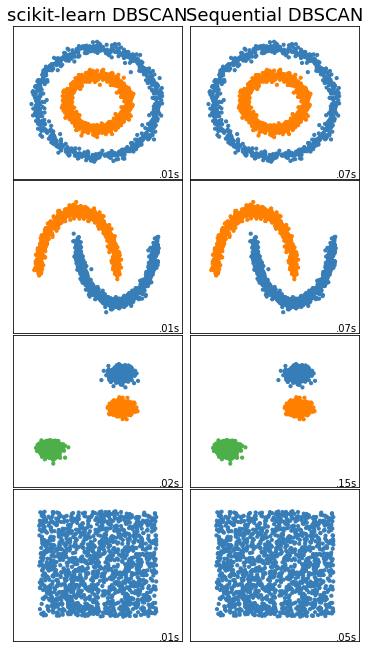

In [ ]:
plt.figure(figsize=(num_DBSCAN_algorithms * 2 + 1, 9))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)
plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    ###
    ### INCLUDE DBSCAN IMPLEMENTATION
    # include your implementations for comparison here
    # 1) create an instances of your DBSCAN class
    # 2) add it to the dbscan_algorithms tuple
    sklearn_dbscan = cluster.DBSCAN(eps=params["eps"], min_samples=params["min_samples"])
    seq_dbscan = Sequential_DBSCAN(eps=params["eps"], min_samples=params["min_samples"])
    dbscan_algorithms = (("scikit-learn DBSCAN", sklearn_dbscan),
                         ("Sequential DBSCAN", seq_dbscan),)
    ### END
    ###

    for name, algorithm in dbscan_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        y_pred = algorithm.labels_.astype(int)          
        
        plt.subplot(len(datasets), len(dbscan_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(["#377eb8",
                                             "#ff7f00",
                                             "#4daf4a",
                                             "#f781bf",
                                             "#a65628",
                                             "#984ea3",
                                             "#999999",
                                             "#e41a1c",
                                             "#dede00",]),
                                      int(max(y_pred) + 1),)))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(0.99, 0.01, ("%.2fs" % (t1 - t0)).lstrip("0"), 
                 transform=plt.gca().transAxes, size=10, horizontalalignment="right",)
        plot_num += 1

plt.show()

    

# **Local Scanning Problematic**

In [ ]:
import pyspark.sql.functions as F
from random import choice

def pre_process(list_of_points):
  rdd_pts = sc.parallelize(list_of_points.tolist()).zipWithIndex()
  df_pts = spark.createDataFrame(rdd_pts, schema=['pts','pts_id'])
  df_pts = df_pts.select('pts_id',df_pts.pts[0].alias('x'),df_pts.pts[1].alias('y')\
                       ,F.lit(0).alias('dis_key'),F.lit(-2).alias('status'))
  return df_pts

# Sample one record
def sample_one_row(df_pts):
    df_sample = df_pts.sample(1/df_pts.count())
    while df_sample.count() == 0:
        df_sample = df_pts.sample(1/df_pts.count())
    return df_sample.withColumnRenamed("pts_id","scanning_pts_id")\
            .withColumnRenamed("x","scanning_x")\
            .withColumnRenamed("y","scanning_y")\
            .withColumnRenamed("status","scanning_status").limit(1)

# Input all data df_pts, sampled point df_sample, radiu dis_thre, minPoints num_thre and one cluster ID
def find_cluster(df_pts,df_sample,dis_thre,num_thre,cluster_id):
    # Table of unscanned points, initialize with a random point
    df_unscanned = df_sample
    # Store the index scanned to update status, initialize with sample point
    df_update_idx = df_unscanned.select(df_unscanned["scanning_pts_id"].alias("pts_id"),\
                                        F.lit(cluster_id).alias("scanning_status"))
    start = True
    add_cluster_id = True
    
    while len(df_unscanned.take(1))>0:
        # Calculate distance to each points and filter
        df_dis = df_pts.join(df_unscanned,on = 'dis_key',how='leftouter')

        df_dis = df_dis.where(((df_dis.scanning_x-df_dis.x)**2+(df_dis.scanning_y-df_dis.y)**2 <= dis_thre) & \
                      (df_dis.pts_id != df_dis.scanning_pts_id))
        #df_dis.persist()
        
        print('df_dis')
        df_dis.show()

        # count each scanned points
        df_dis_count = df_dis.groupBy('scanning_pts_id').count()
        # pick out core points
        df_core = df_dis_count.where(df_dis_count['count'] > num_thre)
        #df_core.cache()
        # label initial ramdom point as noise if not core
        if start and len(df_core.take(1)) == 0:
            df_update_idx = df_update_idx.select(df_update_idx.pts_id,\
                                        F.lit(-1).alias("scanning_status"))
            add_cluster_id = False
            break

        start = False
            
        # renew unscanned point list after removing scanned points
        df_unscanned = df_dis.join(df_core,on = 'scanning_pts_id',how='inner')
       
        df_unscanned = df_unscanned.join(df_update_idx,df_dis.pts_id==df_update_idx.pts_id,how='left')\
            .where(df_update_idx.scanning_status.isNull())\
            .select(df_dis['pts_id'].alias('scanning_pts_id'),df_dis['dis_key'],df_dis['x'].alias('scanning_x')\
            ,df_dis['y'].alias('scanning_y')).distinct()
        df_unscanned.cache()
        #print(df_unscanned.count())

        # update the index list used to update df_pts
        df_update_idx = df_update_idx.union(df_dis.select('pts_id',F.lit(cluster_id).alias('scanning_status')))\
                                .select('pts_id',F.lit(cluster_id).alias('scanning_status'))\
                                .distinct()
        #df_update_idx.cache()
        print(df_update_idx.count())
    
    print('Before join')
    df_update_idx.show()
    df_pts.show()

    # Update status in df_pts
    df_pts = df_pts.join(df_update_idx,on='pts_id',how='left')\
            .select('pts_id','x','y','dis_key',F.greatest(df_pts.status,df_update_idx.scanning_status)\
                    .alias('status'))

    print('After')
    df_pts.show()        
    
    return df_pts, add_cluster_id

# DBSCAN
def local_dbscan(df_pts,radiu,minpt):
    unscanned = df_pts.where(df_pts.status == -2)
    cluster_id = 0
    result = df_pts
    while len(unscanned.take(1))>0:
        df_sample = sample_one_row(unscanned)
        result, add_cluster_id = find_cluster(result,df_sample,radiu,minpt,cluster_id)
        if add_cluster_id:
            cluster_id += 1
        unscanned = result.where(result.status == -2)
    return result